In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for custom system fonts
import os
from matplotlib import font_manager as fm

In [2]:
# grab system font
fpath = os.path.join('/Users/marley/Library/Fonts/CENSCBK.TTF')
prop = fm.FontProperties(fname=fpath, size=8.5)
fname = os.path.split(fpath)[1]   

## Load spatial data

In [3]:
# load US counties SHP
gdf_full = gpd.read_file('BLS/GIS Data/usa_census_counties_2018_20m/')
gdf_full.set_index('GEOID', inplace=True)

# drop non-continental columns (AK, HI, & PR)
mask_non_continental = ((gdf_full['STATEFP'] == '02') | (gdf_full['STATEFP'] == '15') | (gdf_full['STATEFP'] == '72'))
gdf_continental = gdf_full[~mask_non_continental]

states = gpd.read_file('BLS/GIS Data/tl_2020_us_state/')
mask_non_continental = ((states['STATEFP'] == '02') | (states['STATEFP'] == '15') | (states['STATEFP'] == '72') |
                        (states['STATEFP'] == '78') | (states['STATEFP'] == '69') | (states['STATEFP'] == '66') |
                        (states['STATEFP'] == '60'))
states48 = states[~mask_non_continental]

In [4]:
gdf_continental = gdf_continental.to_crs(epsg=5070)
states48 = states48.to_crs(epsg=5070)

## Manufacturing

In [22]:
# load processed NAICS data
code = '31'
path = 'BLS/BLS_gh/my_naics_chg/naics_'
df = pd.read_csv(path + code + '.csv')

# clean FIPS and set as index
df['fips'] = df['fips'].astype(str).str.zfill(5)
df = df.set_index('fips')

In [23]:
# calculate net change cols
df['net_chg_90_20'] = (df['annual_avg_emplvl_20'] - df['annual_avg_emplvl_90'])
df['net_chg_00_10'] = (df['annual_avg_emplvl_10'] - df['annual_avg_emplvl_00'])
df['net_chg_10_20'] = (df['annual_avg_emplvl_20'] - df['annual_avg_emplvl_10'])

In [24]:
# merge with continental gdf
gdf = gdf_continental.merge(df, how='left', left_index=True, right_index=True)

In [25]:
gdf.net_chg_00_10.describe()

count      3107.000000
mean      -1844.720631
std        7235.655233
min     -242014.000000
25%       -1411.000000
50%        -369.000000
75%           0.000000
max       22222.000000
Name: net_chg_00_10, dtype: float64

In [26]:
# create job LOSS categories
cats = ['Job gain or no loss', '-1 to -1,000', '-1,001 to -2,000', '-2,001 or greater']

cond = gdf['net_chg_00_10'] >= 0
gdf.loc[cond, 'graph'] = cats[0]

cond = (gdf['net_chg_00_10'] < 0) & (gdf['net_chg_00_10'] >= -1000)
gdf.loc[cond, 'graph'] = cats[1]

cond = (gdf['net_chg_00_10'] < -1000) & (gdf['net_chg_00_10'] >= -2000)
gdf.loc[cond, 'graph'] = cats[2]

cond = gdf['net_chg_00_10'] < -2000
gdf.loc[cond, 'graph'] = cats[3]

gdf.graph.value_counts()

-1 to -1,000           1315
Job gain or no loss     825
-2,001 or greater       622
-1,001 to -2,000        345
Name: graph, dtype: int64

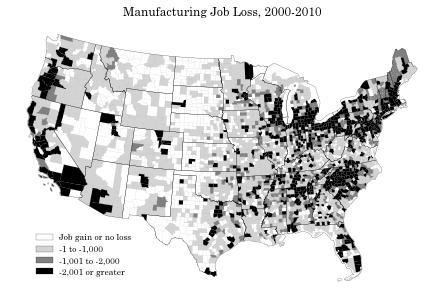

In [27]:
# map job gain time

mask0 = gdf.graph == cats[0]
mask1 = gdf.graph == cats[1]
mask2 = gdf.graph == cats[2]
mask3 = gdf.graph == cats[3]

fig, ax = plt.subplots(figsize=(9,5))

counties0 = gdf[mask0].plot(ax=ax, edgecolor='black', lw=0.025, color='white')
counties1 = gdf[mask1].plot(ax=ax, edgecolor='black', lw=0.025, color='lightgray')
counties2 = gdf[mask2].plot(ax=ax, edgecolor='black', lw=0.025, color='gray')
counties3 = gdf[mask3].plot(ax=ax, edgecolor='black', lw=0.025, color='black')

states48.plot(ax=ax, facecolor='None', edgecolor='black', lw=0.2)

white = mpatches.Patch(facecolor='white', edgecolor='black', lw=.2, label=cats[0])
lgray = mpatches.Patch(facecolor='lightgray', edgecolor='black', lw=.2, label=cats[1])
dgray = mpatches.Patch(facecolor='gray', edgecolor='black', lw=.2, label=cats[2])
black = mpatches.Patch(facecolor='black', edgecolor='black', lw=.2, label=cats[3])

legend = ax.legend(prop=prop, handles=[white, lgray, dgray, black],
                   bbox_to_anchor=(.315, .26), frameon=False, fancybox=False,
                   edgecolor='black', borderpad=.8, labelspacing=.4,)

#legend.get_frame().set_linewidth(0.2)

title = 'Manufacturing Job Loss, 2000-2010'
ax.set_title(title, fontsize = 12, fontproperties=prop)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

# save figure
ax.get_figure().savefig('graphics/jpgs/ch2_fig22.jpg', dpi=600, bbox_inches='tight')
ax.get_figure().savefig('graphics/pdfs/ch2_fig22.pdf', dpi=600, bbox_inches='tight')

In [28]:
# create job GAIN categories
cats = ['Job loss or no gain', '1 to 1,000', '1,001 to 2,000', '2,001 or greater']

cond = gdf.net_chg_10_20 <= 0
gdf.loc[cond, 'graph2'] = cats[0]

cond = (gdf['net_chg_10_20'] > 0) & (gdf['net_chg_00_10'] <= 1000)
gdf.loc[cond, 'graph2'] = cats[1]

cond = (gdf['net_chg_10_20'] > 1000) & (gdf['net_chg_00_10'] <= 2000)
gdf.loc[cond, 'graph2'] = cats[2]

cond = gdf.net_chg_10_20 > 2000
gdf.loc[cond, 'graph2'] = cats[3]

gdf.graph2.value_counts()

Job loss or no gain    1457
1 to 1,000             1350
2,001 or greater        147
1,001 to 2,000          145
Name: graph2, dtype: int64

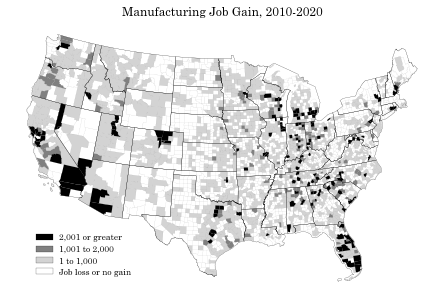

In [29]:
# map job gain time

mask0 = gdf.graph2 == cats[0] 
mask1 = gdf.graph2 == cats[1]
mask2 = gdf.graph2 == cats[2]
mask3 = gdf.graph2 == cats[3]

fig, ax = plt.subplots(figsize=(9,5))

counties0 = gdf[mask0].plot(ax=ax, edgecolor='black', lw=0.025, color='white')
counties1 = gdf[mask1].plot(ax=ax, edgecolor='black', lw=0.025, color='lightgray')
counties2 = gdf[mask2].plot(ax=ax, edgecolor='black', lw=0.025, color='gray')
counties3 = gdf[mask3].plot(ax=ax, edgecolor='black', lw=0.025, color='black')

states48.plot(ax=ax, facecolor='None', edgecolor='black', lw=0.2)

white = mpatches.Patch(facecolor='white', edgecolor='black', lw=.2, label=cats[0])
lgray = mpatches.Patch(facecolor='lightgray', edgecolor='black', lw=.2, label=cats[1])
dgray = mpatches.Patch(facecolor='gray', edgecolor='black', lw=.2, label=cats[2])
black = mpatches.Patch(facecolor='black', edgecolor='black', lw=.2, label=cats[3])

legend = ax.legend(prop=prop, handles=[black, dgray, lgray, white],
                   bbox_to_anchor=(.315, .26), frameon=False, fancybox=False,
                   edgecolor='black', borderpad=.8, labelspacing=.4,)

#legend.get_frame().set_linewidth(0.2)

title = 'Manufacturing Job Gain, 2010-2020'
ax.set_title(title, fontsize = 12, fontproperties=prop)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

# save figure
ax.get_figure().savefig('graphics/jpgs/ch2_fig23.jpg', dpi=600, bbox_inches='tight')
ax.get_figure().savefig('graphics/pdfs/ch2_fig23.pdf', dpi=600, bbox_inches='tight')

## Mining

In [30]:
# load processed NAICS data
code = '21'
path = 'BLS/BLS_gh/my_naics_chg/naics_'
df = pd.read_csv(path + code + '.csv')

# clean FIPS and set as index
df['fips'] = df['fips'].astype(str).str.zfill(5)
df = df.set_index('fips')

In [31]:
# calculate net change col
df['net_chg_10_20'] = (df['annual_avg_emplvl_20'] - df['annual_avg_emplvl_10'])

In [32]:
# merge with continental gdf
gdf = gdf_continental.merge(df, how='left', left_index=True, right_index=True)

In [33]:
miningmask = gdf['annual_avg_emplvl_10'] != 0
print(gdf.shape, gdf[miningmask].shape)

(3108, 26) (1162, 26)


In [34]:
# create job LOSS categories
cats = ['Job gain or no loss', '-1 to -500', '-501 to -1,000', '-1,001 or greater']

cond = gdf['net_chg_10_20'] >= 0
gdf.loc[cond, 'graph'] = cats[0]

cond = (gdf['net_chg_10_20'] < 0) & (gdf['net_chg_10_20'] >= -500)
gdf.loc[cond, 'graph'] = cats[1]

cond = (gdf['net_chg_10_20'] < -500) & (gdf['net_chg_10_20'] >= -1000)
gdf.loc[cond, 'graph'] = cats[2]

cond = gdf['net_chg_10_20'] < -1000
gdf.loc[cond, 'graph'] = cats[3]

gdf.graph.value_counts()

Job gain or no loss    2327
-1 to -500              703
-1,001 or greater        42
-501 to -1,000           35
Name: graph, dtype: int64

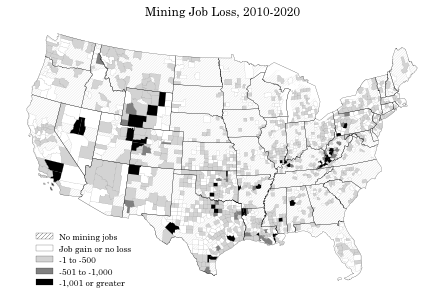

In [41]:
# map job gain time

mask0 = gdf.graph == cats[0]
mask1 = gdf.graph == cats[1]
mask2 = gdf.graph == cats[2]
mask3 = gdf.graph == cats[3]

fig, ax = plt.subplots(figsize=(9,5))
plt.rcParams['hatch.linewidth'] = .25
plt.rcParams['hatch.color'] = 'gray'

gdf.plot(ax=ax, color='None', edgecolor='lightgray', lw=0.0001, hatch='/////////')

counties0 = gdf[mask0 & miningmask].plot(ax=ax, edgecolor='black', lw=0.05, color='white')
counties1 = gdf[mask1 & miningmask].plot(ax=ax, edgecolor='black', lw=0.05, color='lightgray')
counties2 = gdf[mask2 & miningmask].plot(ax=ax, edgecolor='black', lw=0.05, color='gray')
counties3 = gdf[mask3 & miningmask].plot(ax=ax, edgecolor='black', lw=0.05, color='black')

states48.plot(ax=ax, facecolor='None', edgecolor='black', lw=0.2)

hatch = mpatches.Patch(facecolor='None', edgecolor='black', hatch='//////', lw=.2, label='No mining jobs')
white = mpatches.Patch(facecolor='white', edgecolor='black', lw=.2, label=cats[0])
lgray = mpatches.Patch(facecolor='lightgray', edgecolor='black', lw=.2, label=cats[1])
dgray = mpatches.Patch(facecolor='gray', edgecolor='black', lw=.2, label=cats[2])
black = mpatches.Patch(facecolor='black', edgecolor='black', lw=.2, label=cats[3])

legend = ax.legend(prop=prop, handles=[hatch, white, lgray, dgray, black],
                   bbox_to_anchor=(.315, .26), frameon=False, fancybox=False,
                   edgecolor='black', borderpad=.8, labelspacing=.4,)

#legend.get_frame().set_linewidth(0.2)

title = 'Mining Job Loss, 2010-2020'
ax.set_title(title, fontsize=12, fontproperties=prop)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', left=False, bottom=False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

# save figure
ax.get_figure().savefig('graphics/jpgs/ch3_fig29.jpg', dpi=600, bbox_inches='tight')
ax.get_figure().savefig('graphics/pdfs/ch3_fig29.pdf', dpi=600, bbox_inches='tight')

## CDC data

In [44]:
# load processed NAICS data
file = 'ch3_fig30.csv'
df = pd.read_csv('data_files/' + file)
df = df.dropna(axis=1)
df.sample(7)

,YEAR,STATE,RATE,DEATHS
33,2020,MS,21.1,586
9,2020,CT,39.1,1371
27,2020,NY,25.4,4965
49,2020,SD,10.3,83
40,2020,GA,18.0,1916
48,2020,NE,11.3,214
16,2020,MA,33.9,2302


In [45]:
# merge with states
gdf = states48.merge(df, how='left', left_on='STUSPS', right_on='STATE')
gdf.sample(5)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,YEAR,STATE,RATE,DEATHS
15,2,3,55,01779806,55,WI,Wisconsin,00,G4000,A,140292246684,29343721650,+44.6309071,-089.7093916,"POLYGON ((242732.718 2521319.808, 242758.959 2...",2020.0,WI,27.7,1531.0
48,4,8,04,01779777,04,AZ,Arizona,00,G4000,A,294360991275,858853288,+34.2039362,-111.6063449,"POLYGON ((-1708178.567 1273350.599, -1708189.6...",2020.0,AZ,35.8,2550.0
22,3,6,01,01779775,01,AL,Alabama,00,G4000,A,131175460655,4591915034,+32.7396323,-086.8434593,"POLYGON ((714520.761 1309574.792, 714521.219 1...",2020.0,AL,22.3,1029.0
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151895765,6979171386,+38.9466584,-076.6744939,"POLYGON ((1576009.385 1953829.027, 1576016.637...",2020.0,MD,44.6,2771.0
12,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,314198560935,726482115,+34.4346843,-106.1316181,"POLYGON ((-880589.107 1596628.585, -880501.218...",2020.0,NM,39.0,784.0


In [50]:
# create mort rate categories
cats = ['1 to 20', '21 to 40', '41 to 60', '61 to 80', '81 or above']

cond = gdf['RATE'] < 20
gdf.loc[cond, 'graph'] = cats[0]

cond = (gdf['RATE'] > 20) & (gdf['RATE'] <= 40)
gdf.loc[cond, 'graph'] = cats[1]

cond = (gdf['RATE'] > 40) & (gdf['RATE'] <= 60)
gdf.loc[cond, 'graph'] = cats[2]

cond = (gdf['RATE'] > 61) & (gdf['RATE'] <= 80)
gdf.loc[cond, 'graph'] = cats[3]

cond = gdf['RATE'] > 80
gdf.loc[cond, 'graph'] = cats[4]

gdf.graph.value_counts()

21 to 40       26
1 to 20        14
41 to 60        7
81 or above     1
Name: graph, dtype: int64

In [ ]:
states0 = gdf[mask0].plot(ax=ax, edgecolor='black', lw=0.05, color='white')
states1 = gdf[mask1].plot(ax=ax, edgecolor='black', lw=0.05, color='lightgray')
states2 = gdf[mask2].plot(ax=ax, edgecolor='black', lw=0.05, color='gray')
states3 = gdf[mask3].plot(ax=ax, edgecolor='black', lw=0.05, color='black')
states4 = gdf[mask3].plot(ax=ax, edgecolor='black', lw=0.05, color='black')

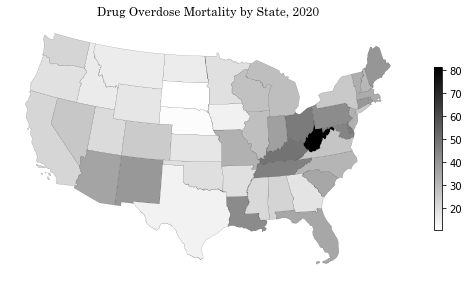

In [47]:
# mapping time
ax = gdf.plot(column='RATE', edgecolor='black', lw=0.1, cmap='binary', legend=True, legend_kwds={'shrink': 0.6}, figsize=(9,5))
              
#states48.plot(ax=ax, facecolor='None', edgecolor='black', lw=0.2)
    
title = 'Drug Overdose Mortality by State, 2020'
ax.set_title(title, fontsize = 12, fontproperties=prop)
ax.axis("off")

# save figure
ax.get_figure().savefig('graphics/jpgs/ch3_fig30.jpg', dpi=600, bbox_inches='tight')
ax.get_figure().savefig('graphics/pdfs/ch3_fig30.pdf', dpi=600, bbox_inches='tight')